<a href="https://colab.research.google.com/github/CesarC15/projetoML/blob/main/src/deteccao_anomalias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup Infraestrutura e Dados**

In [1]:
pip install kagglehub[pandas-datasets] ydata-profiling imbalanced-learn seaborn matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.7/398.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.7 MB/s eta 0:00:00


In [47]:
import kagglehub
import pandas as pd
import numpy as np
import os
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, roc_auc_score, f1_score, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import LocalOutlierFactor

In [3]:
#Aquisição de Dados
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
file_path = os.path.join(path, 'creditcard.csv')

Using Colab cache for faster access to the 'creditcardfraud' dataset.


In [4]:
df = pd.read_csv(file_path)

print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [ ]:
#Análise Exploratória (EDA)
profile = ProfileReport(df, title="Profiling Report")
profile.to_notebook_iframe()

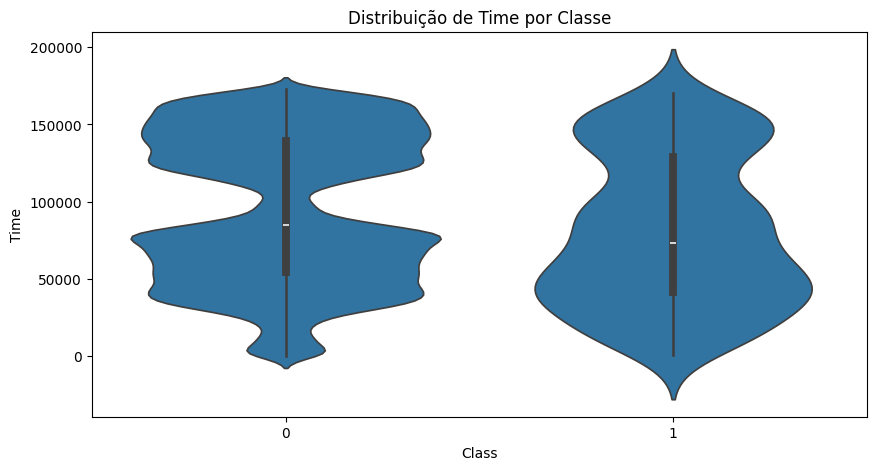

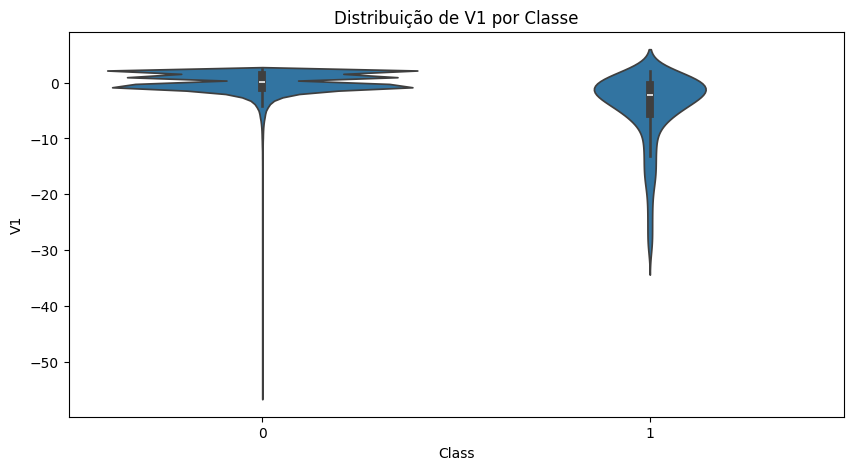

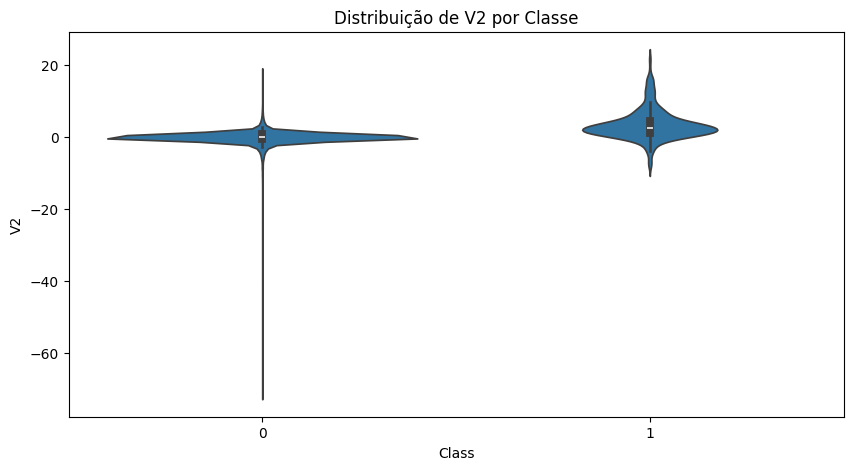

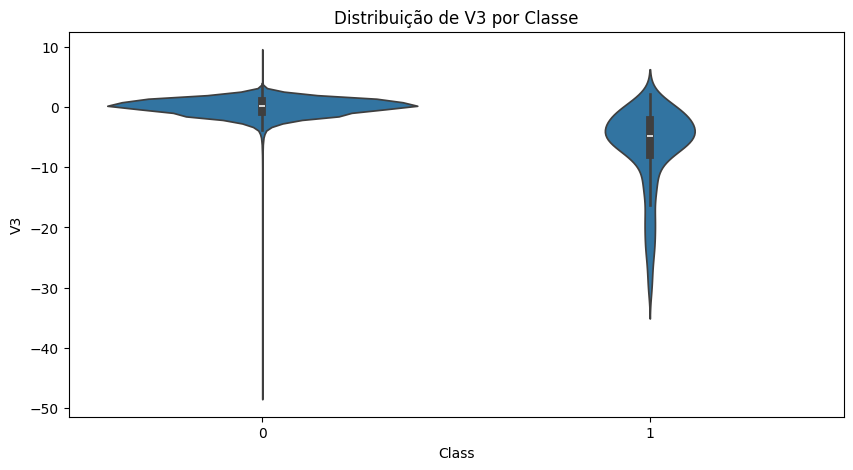

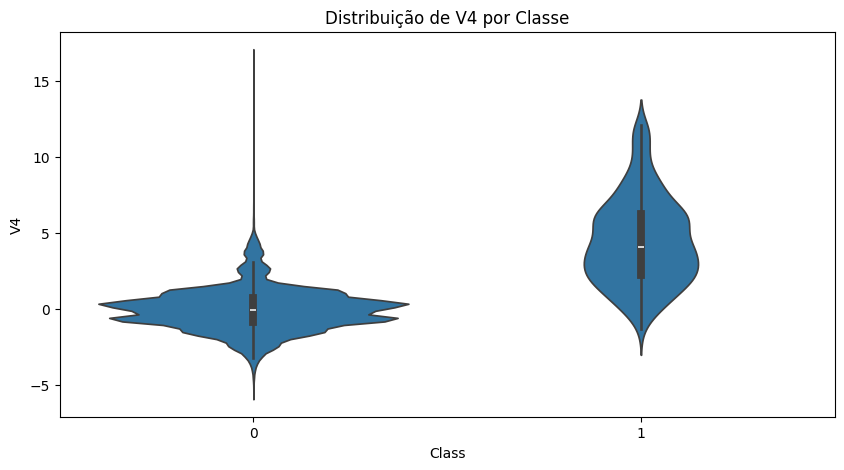

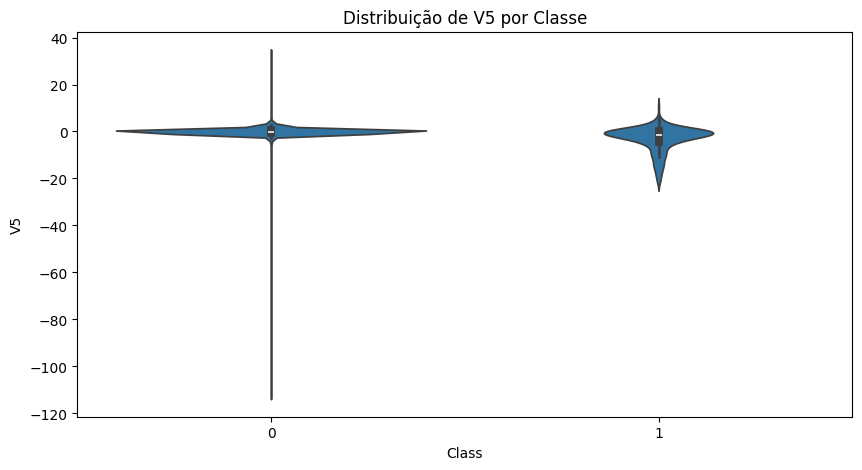

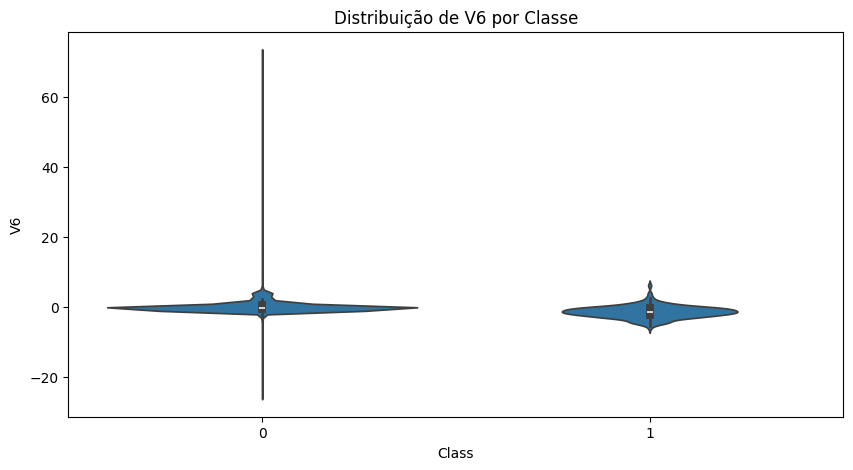

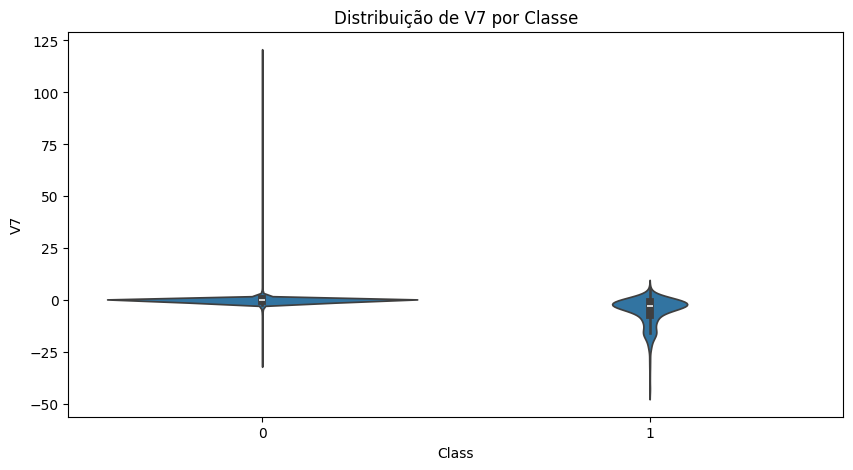

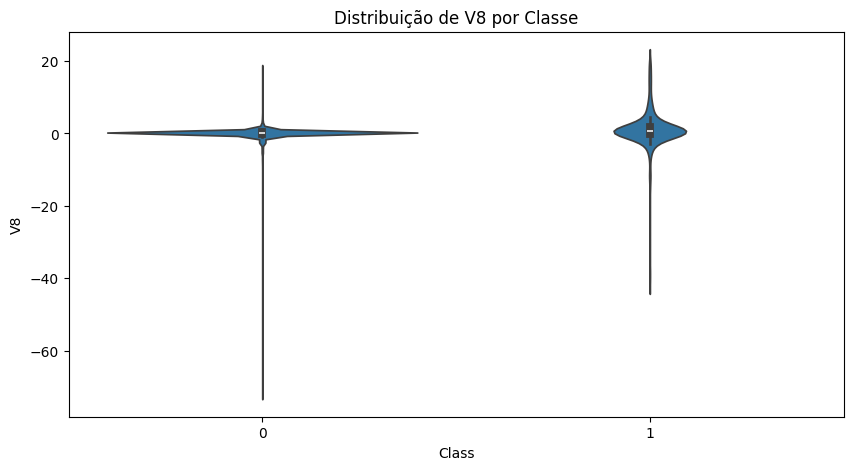

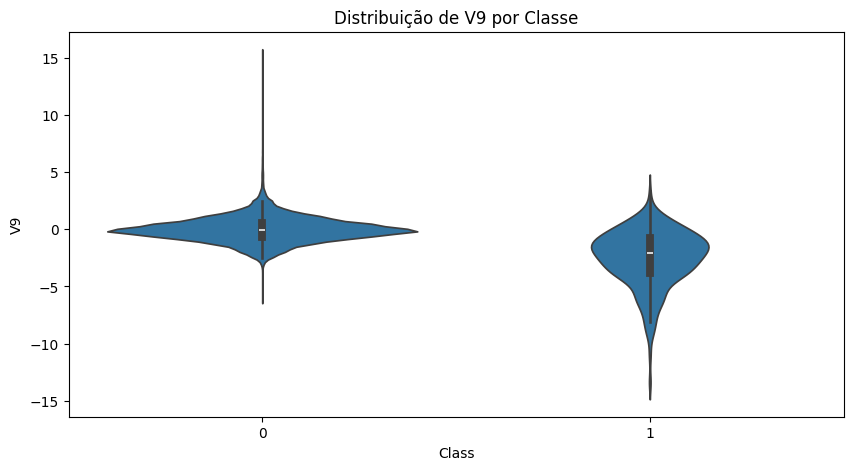

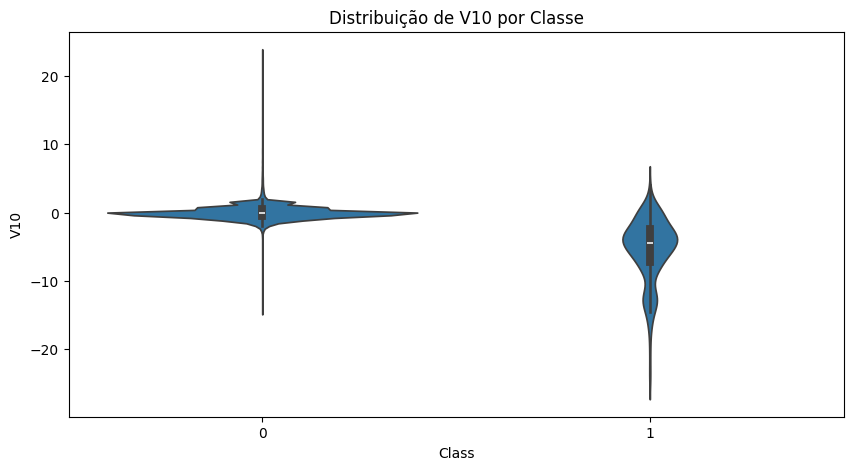

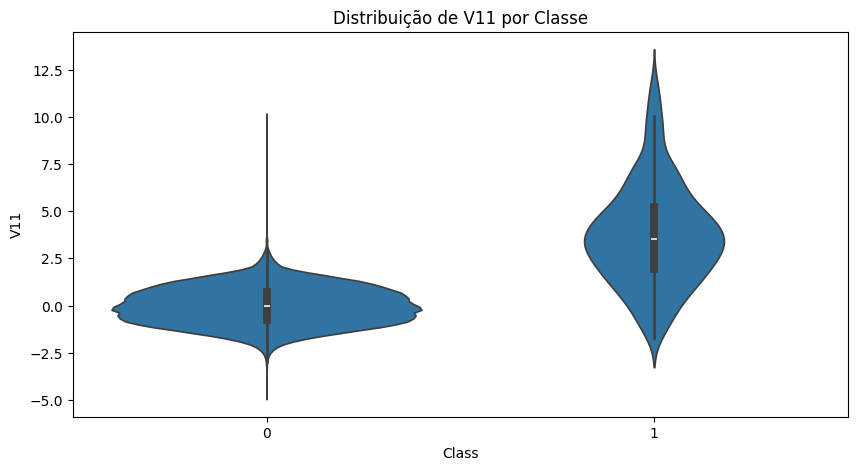

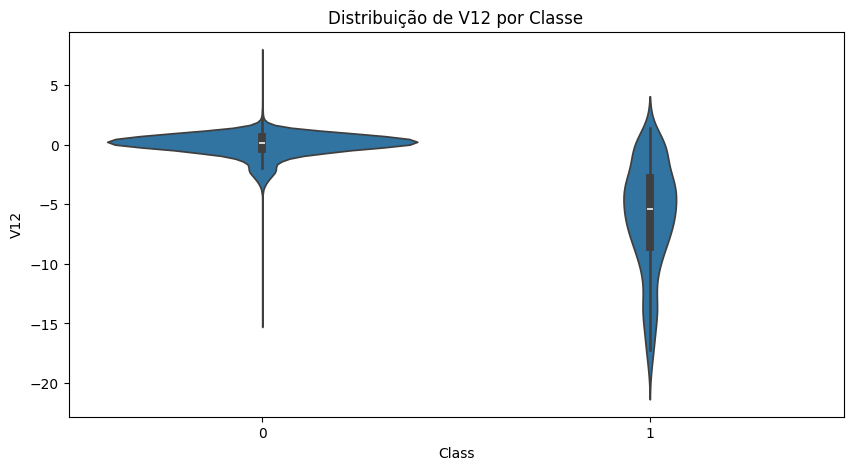

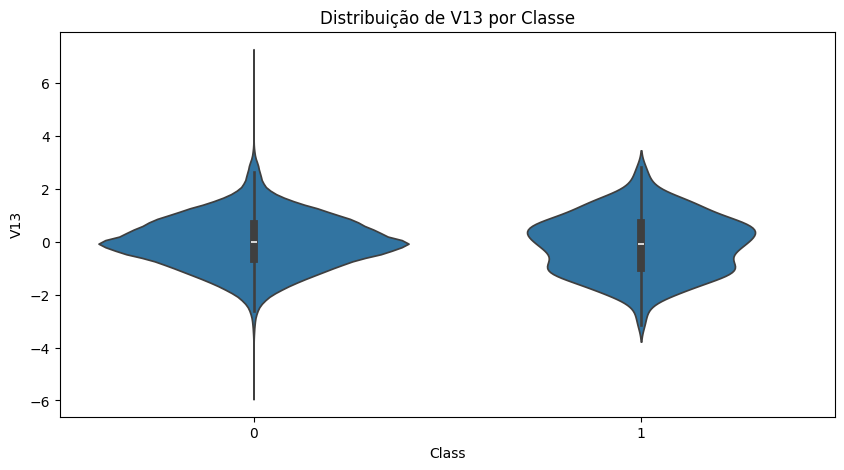

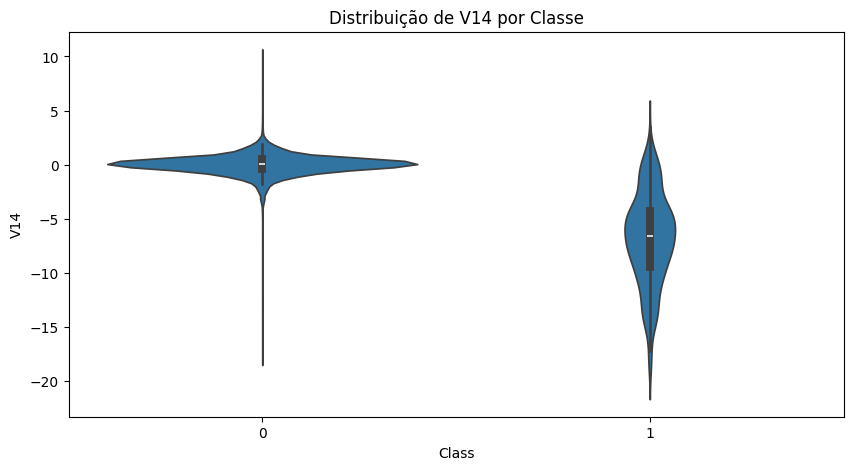

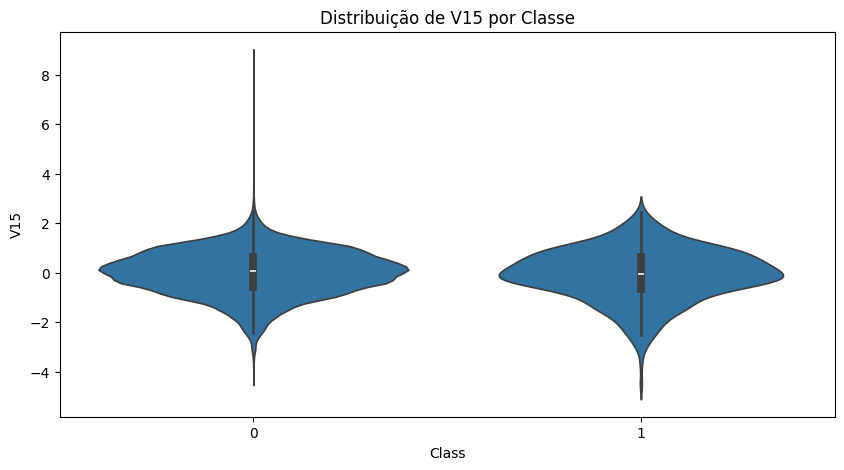

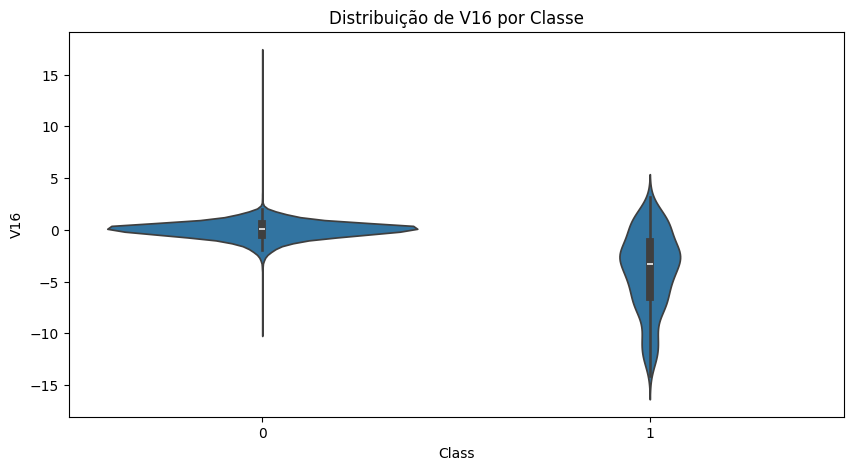

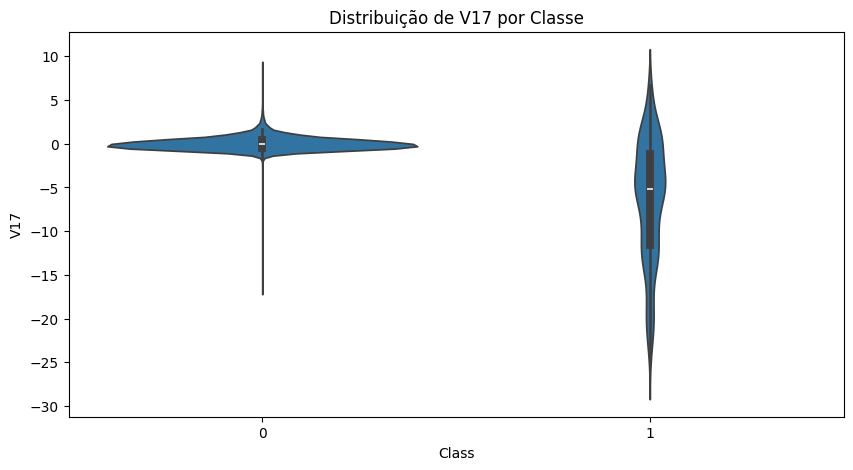

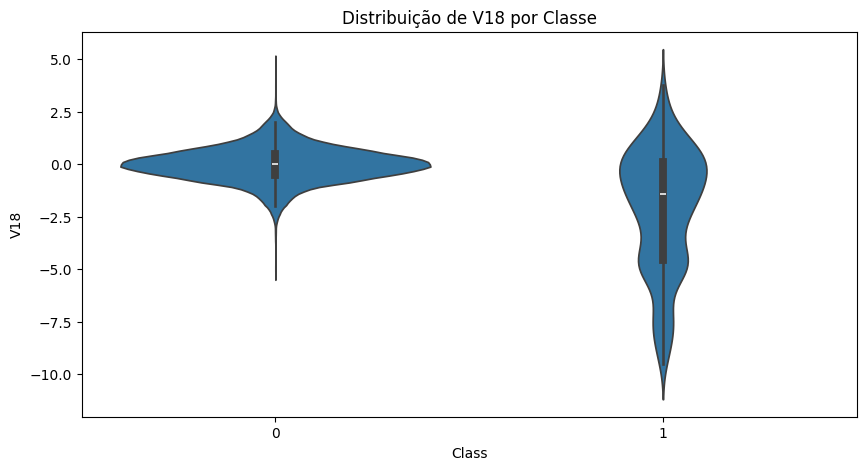

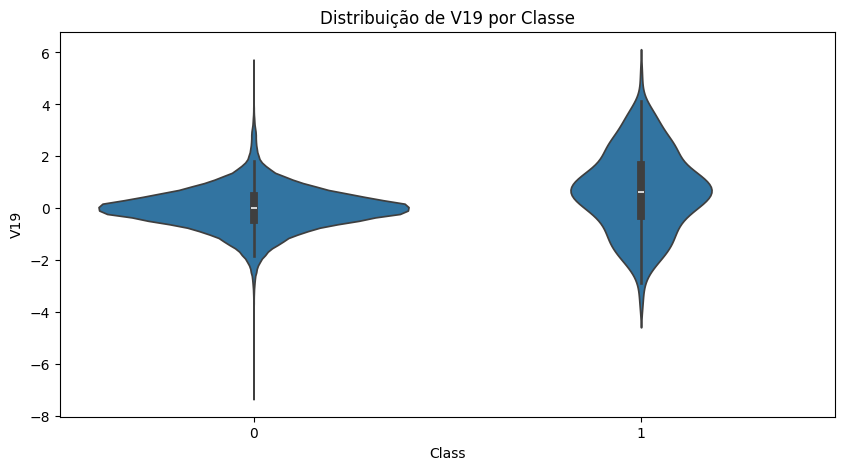

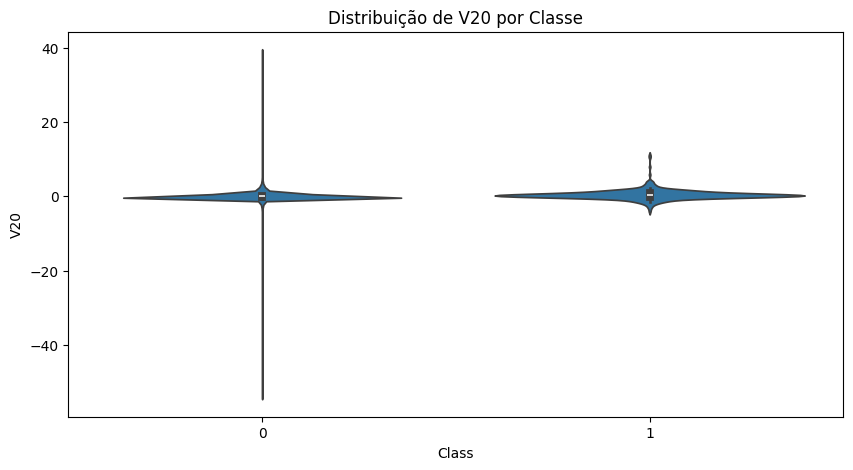

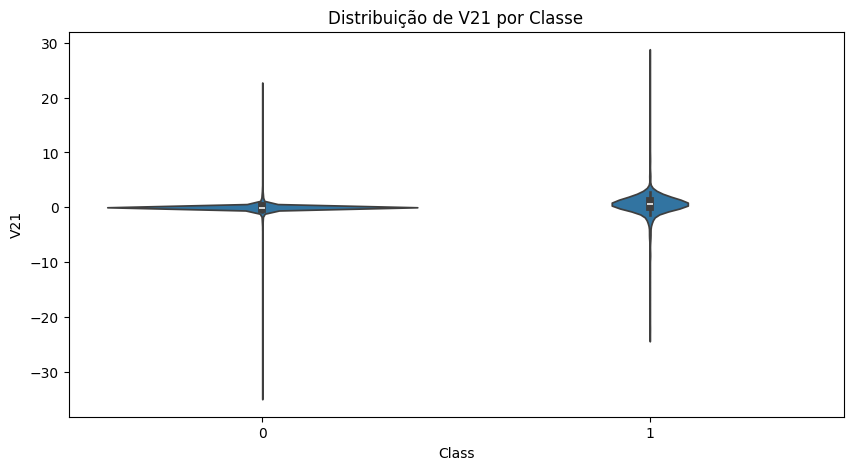

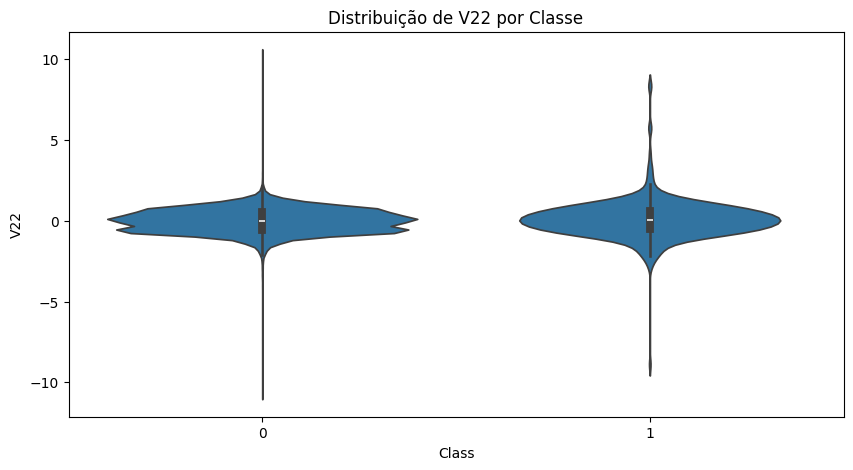

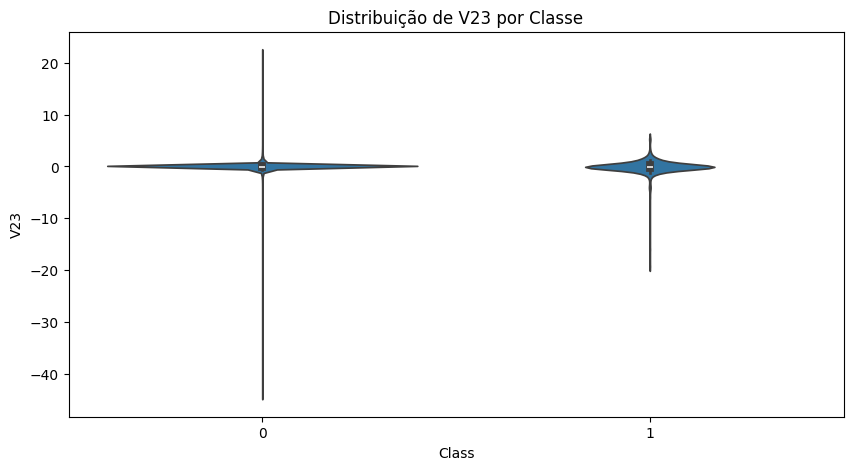

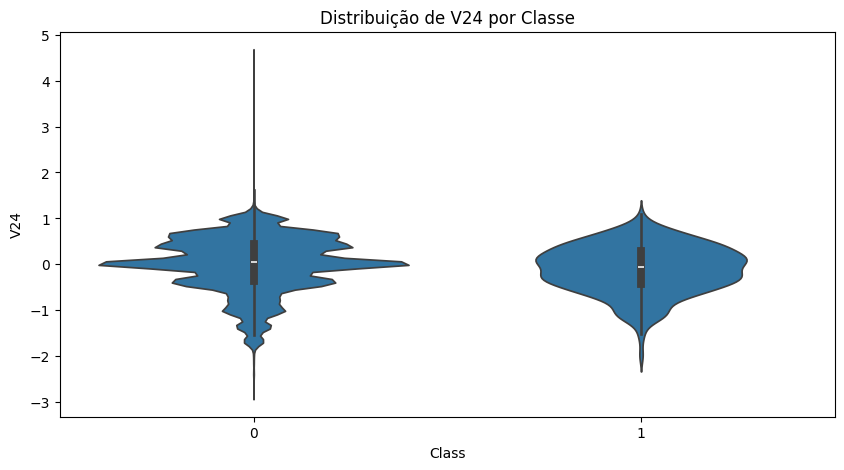

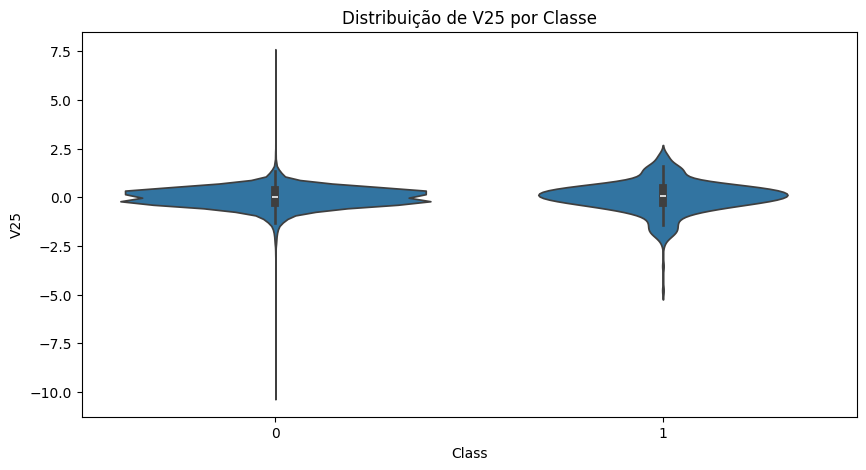

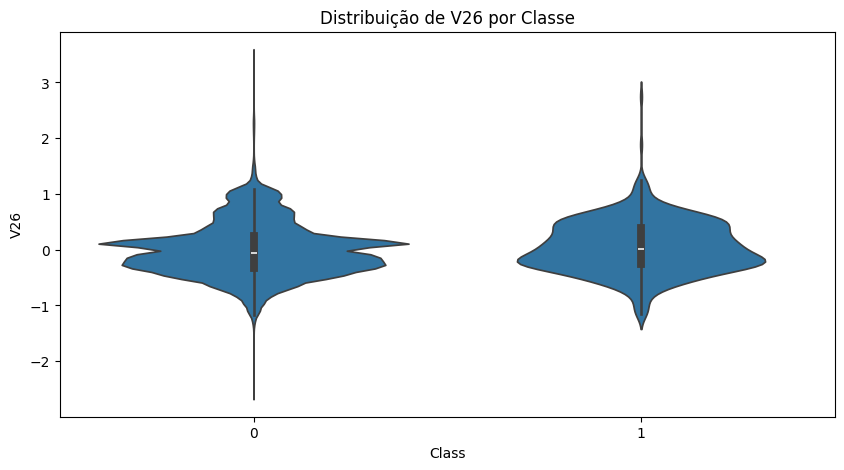

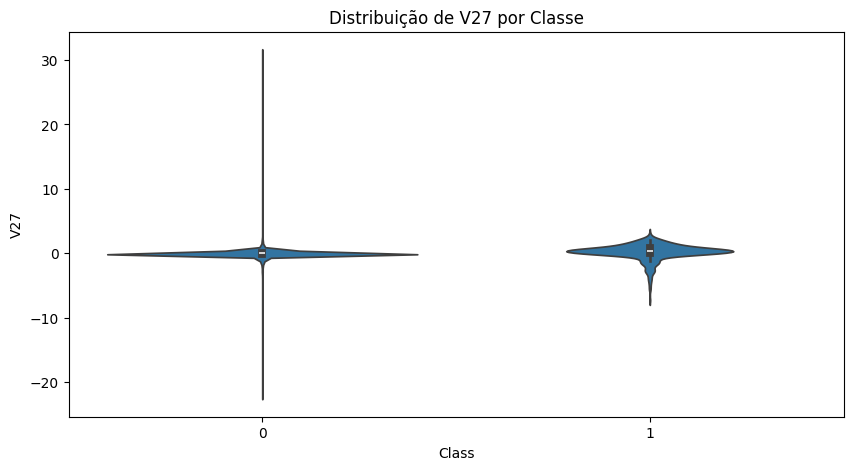

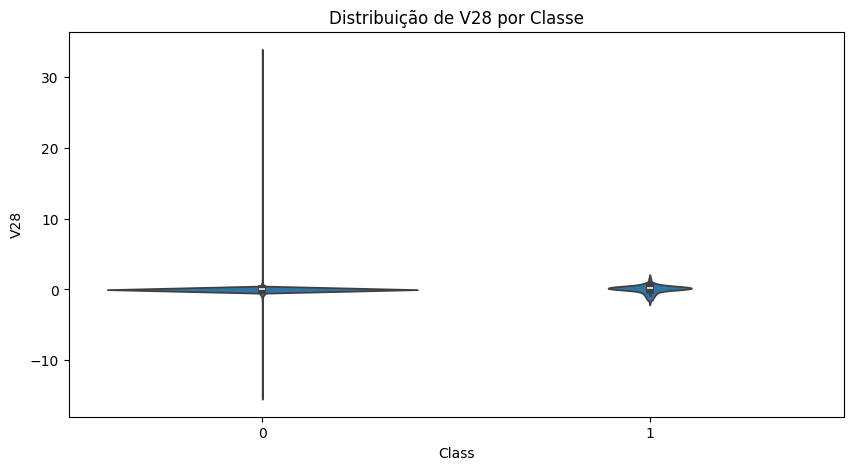

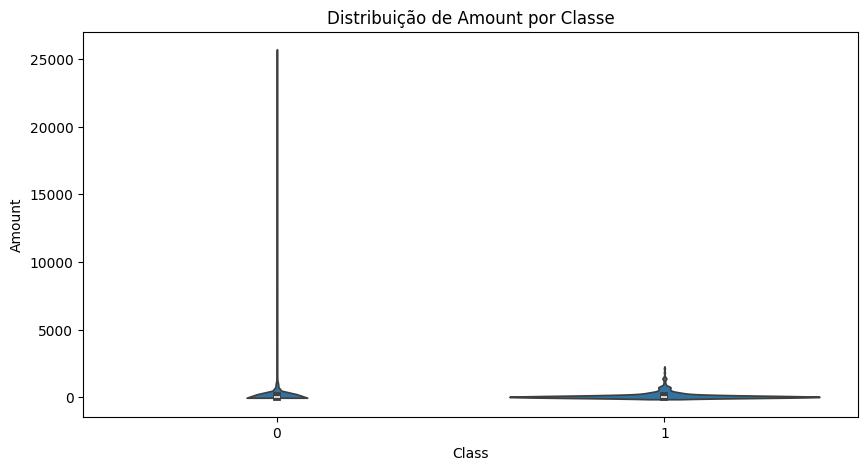

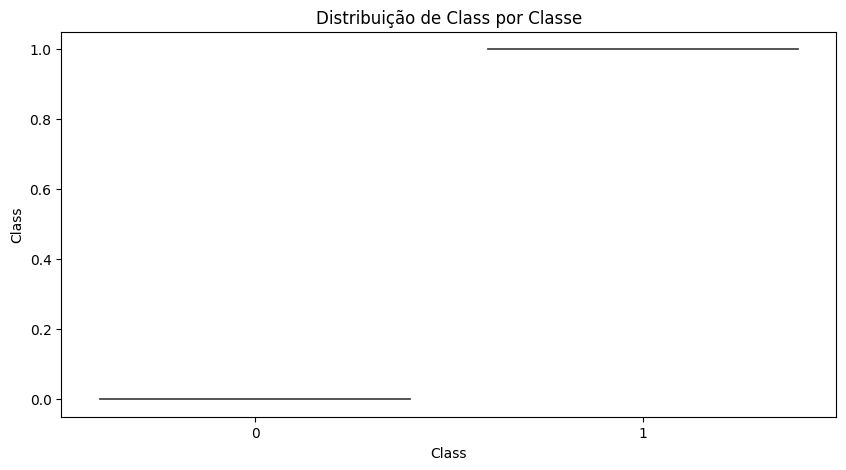

In [ ]:
for column in df:
    plt.figure(figsize=(10, 5))
    sns.violinplot(x='Class', y=column, data=df)
    plt.title(f'Distribuição de {column} por Classe')
    plt.show()

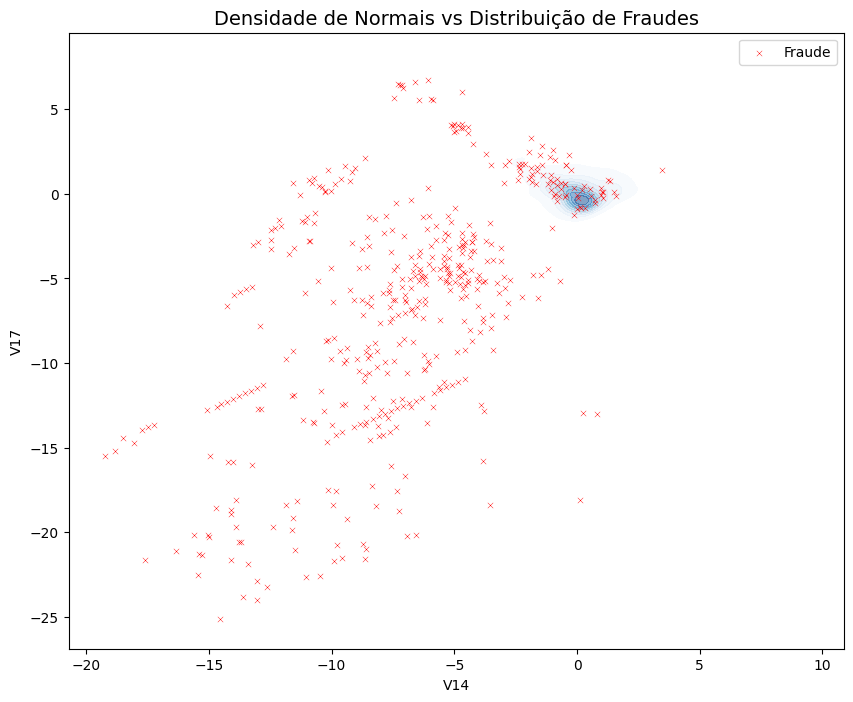

In [ ]:
plt.figure(figsize=(10, 8))

sns.kdeplot(
    data=df[df['Class'] == 0],
    x='V14', y='V17',
    cmap="Blues", fill=True, thresh=0.05, alpha=0.5
)

sns.scatterplot(
    data=df[df['Class'] == 1],
    x='V14', y='V17',
    color='red', s=15, marker='x', label='Fraude'
)

plt.title('Densidade de Normais vs Distribuição de Fraudes', fontsize=14)
plt.legend()
plt.show()

In [5]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [6]:
#Pré-processamento
#----------------#
#Tratamento de Nulos e Duplicatas
print(f"Tamanho com duplicata: {df.shape[0]}")
df.drop_duplicates(inplace=True)
print(f"Tamanho sem duplicata: {df.shape[0]}")

print(f"Número de nulos: {df.isnull().sum().sum()}")

#Scaling e Encoding
##V1 até V28 já passaram por transformação de PCA, precisa normalizar só Time e Ammount
#TODO: Acho que é bom colocar depois no relatório sobre PCA
#Não pode fazer isso antes do split, fica para depois

Tamanho com duplicata: 284807
Tamanho sem duplicata: 283726
Número de nulos: 0


In [7]:
df_normals = df[df['Class'] == 0]
df_frauds = df[df['Class'] == 1]

train_normals, temp_normals = train_test_split(df_normals, test_size=0.3, random_state=RANDOM_STATE)

val_normals, test_normals = train_test_split(temp_normals, test_size=0.5, random_state=RANDOM_STATE)
val_frauds, test_frauds = train_test_split(df_frauds, test_size=0.5, random_state=RANDOM_STATE)

df_train = train_normals.copy()
df_val = pd.concat([val_normals, val_frauds]).sample(frac=1, random_state=RANDOM_STATE)
df_test = pd.concat([test_normals, test_frauds]).sample(frac=1, random_state=RANDOM_STATE)

X_train = df_train.drop('Class', axis=1)
y_train = df_train['Class']

X_val = df_val.drop('Class', axis=1)
y_val = df_val['Class']

X_test = df_test.drop('Class', axis=1)
y_test = df_test['Class']

print(f"Amostras de treino: {X_train.shape[0]}")
print(f"Amostra de teste: {X_test.shape[0]}")
print(f"Amostra de validação: {X_val.shape[0]}")

print(f"Fraudes no treino: {y_train.sum()}")
print(f"Fraudes no teste: {y_test.sum()}")
print(f"Fraudes na validação: {y_val.sum()}")

Amostras de treino: 198277
Amostra de teste: 42725
Amostra de validação: 42724
Fraudes no treino: 0
Fraudes no teste: 237
Fraudes na validação: 236


In [8]:
#Scaling
scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [10]:
#Conjunto para o t-SNE
X_tsne_fraude = X_val[y_val == 1]

X_tsne_normal = X_train
X_tsne_normal = X_tsne_normal.sample(n=20000, random_state=RANDOM_STATE)

X_tsne = pd.concat([X_tsne_fraude, X_tsne_normal])
y_tsne = np.concatenate([
    np.ones(len(X_tsne_fraude)),
    np.zeros(len(X_tsne_normal))
])

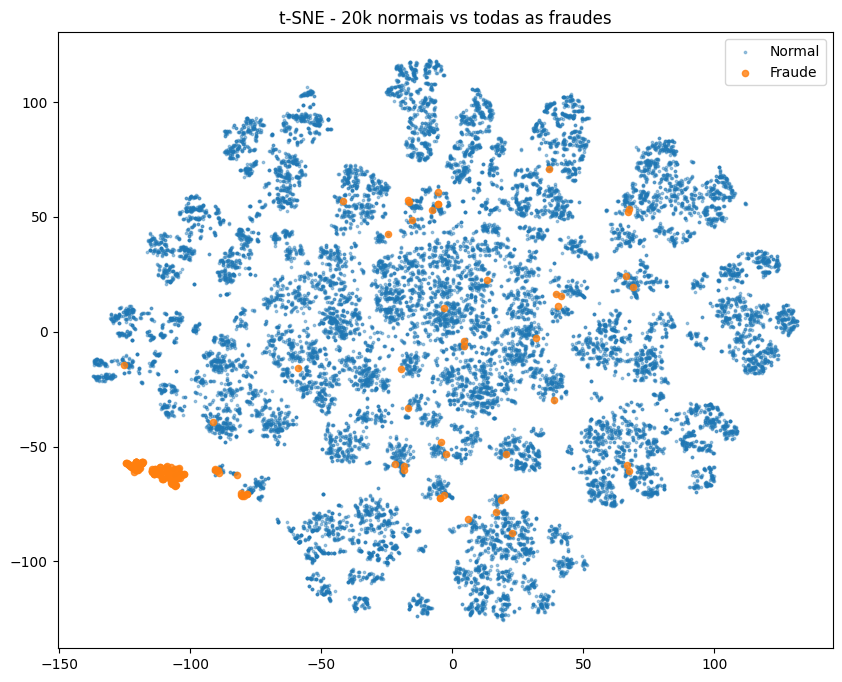

In [11]:
#t-SNE
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='pca',
    max_iter=1500,
    random_state=RANDOM_STATE
)

X_tsne_embedded = tsne.fit_transform(X_tsne)
plt.figure(figsize=(10, 8))

#Normais
plt.scatter(
    X_tsne_embedded[y_tsne == 0, 0],
    X_tsne_embedded[y_tsne == 0, 1],
    s=3, alpha=0.4, label="Normal"
)

#Fraude
plt.scatter(
    X_tsne_embedded[y_tsne == 1, 0],
    X_tsne_embedded[y_tsne == 1, 1],
    s=20, alpha=0.8, label="Fraude"
)

plt.title("t-SNE - 20k normais vs todas as fraudes")
plt.legend()
plt.show()


# **Modelagem Clássica**

In [14]:
#Feature Selection (Feature Engineering)
#Não da para usar o conjunto de treino porque só tem normais lá
rf_selector = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_selector.fit(X_val, y_val)

importances = rf_selector.feature_importances_
feature_names = X_val.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

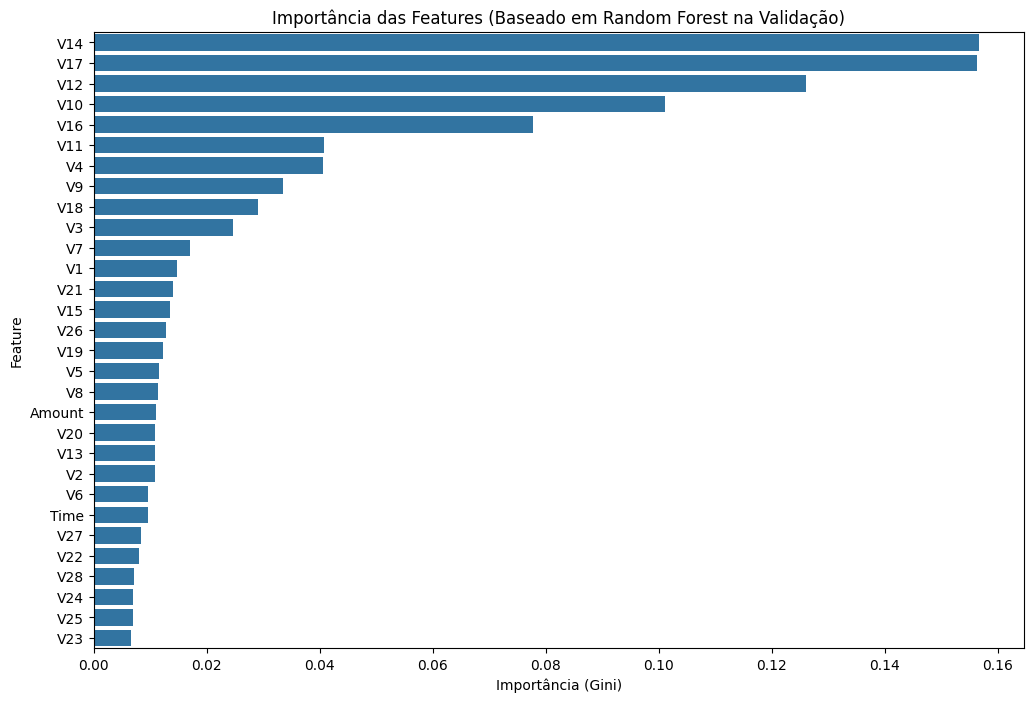

In [17]:
#Grafico com importância das features usando random forest
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Importância das Features (Baseado em Random Forest na Validação)')
plt.xlabel('Importância (Gini)')
plt.ylabel('Feature')
plt.show()

In [20]:
threshold = 0.01
low_importance_features = feature_importance_df[feature_importance_df['Importance'] < threshold]['Feature'].tolist()

print(f"Features com importância abaixo de {threshold}: {len(low_importance_features)}")
print(f"Features menos importantes: {low_importance_features}")

Features com importância abaixo de 0.01: 8
Features menos importantes: ['V6', 'Time', 'V27', 'V22', 'V28', 'V24', 'V25', 'V23']


In [18]:
#Remoção de features menos importantes
cols_to_keep = feature_importance_df[feature_importance_df['Importance'] >= threshold]['Feature'].tolist()
X_train = X_train[cols_to_keep]
X_val = X_val[cols_to_keep]
X_test = X_test[cols_to_keep]
print(f"Novas dimensões do X_train: {X_train.shape}")

Novas dimensões do X_train: (198277, 22)


In [94]:
#Refazendo isolation forest
#Isolation Forest (Probabilístico)
param_grid_if = {
    'n_estimators': [200, 500],
    'max_samples': [128, 256, 512],
    'max_features': [0.6, 0.8, 1.0],
    'bootstrap': [False, True],
}



best_model_if = None
best_score_if = -1
best_params_if = {}

for params in ParameterGrid(param_grid_if):
    model = IsolationForest(
        n_estimators=params['n_estimators'],
        max_samples=params['max_samples'],
        max_features=params['max_features'],
        bootstrap=params['bootstrap'],
        contamination='auto',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    model.fit(X_train)

    scores_val = -model.decision_function(X_val) # Inverte sinal: maior = mais anômalo
    score = average_precision_score(y_val, scores_val)

    if score > best_score_if:
        best_score_if = score
        best_params_if = params
        best_model_if = model
iso_forest = best_model_if

In [100]:
print("Melhores hiperparâmetros IF:", best_params_if)
print("Best AP (val):", best_score_if)
print("Baseline:", y_val.mean())

Melhores hiperparâmetros IF: {'bootstrap': True, 'max_features': 0.8, 'max_samples': 512, 'n_estimators': 200}
Best AP (val): 0.42126004235338654
Baseline: 0.005523827356989046


In [101]:
scores_val_if = -iso_forest.decision_function(X_val)

ap_if = average_precision_score(y_val, scores_val_if)
roc_if = roc_auc_score(y_val, scores_val_if)

print(f"AP (val): {ap_if:.4f}")
print(f"ROC-AUC (val): {roc_if:.4f}")

AP (val): 0.4213
ROC-AUC (val): 0.9561


In [102]:
K = 500
top_k_idx = np.argsort(scores_val_if)[-K:]
recall_at_k = y_val.iloc[top_k_idx].sum() / y_val.sum()
print(f"Recall@{K}: {recall_at_k:.3f}")

Recall@500: 0.708


In [103]:
precision, recall, thresholds = precision_recall_curve(y_val, scores_val_if)

precision = precision[:-1]
recall = recall[:-1]

valid = precision >= 0.6
best_idx_if = np.argmax(recall[valid])
best_threshold_if = thresholds[valid][best_idx_if]

print("Threshold escolhido:", best_threshold_if)
print("Precision:", precision[valid][best_idx_if])
print("Recall:", recall[valid][best_idx_if])

Threshold escolhido: 0.16452341924221148
Precision: 0.6
Recall: 0.3559322033898305


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     42488
      Fraude       0.60      0.36      0.45       236

    accuracy                           1.00     42724
   macro avg       0.80      0.68      0.72     42724
weighted avg       0.99      1.00      0.99     42724



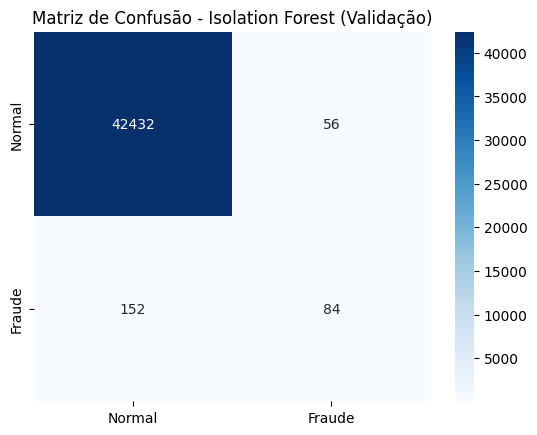

In [104]:
y_pred_if = (scores_val_if >= best_threshold_if).astype(int)

print(classification_report(
    y_val, y_pred_if, target_names=['Normal', 'Fraude']
))

cm = confusion_matrix(y_val, y_pred_if)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraude'], yticklabels=['Normal', 'Fraude'])
plt.title('Matriz de Confusão - Isolation Forest (Validação)')
plt.show()

In [56]:
#LOF
param_grid_lof = {
    'n_neighbors': [20, 50, 100],
    'metric': ['euclidean', 'minkowski'],
    'contamination': ['auto']
}

best_lof_model = None
best_lof_score = -1
best_lof_params = {}

for params in ParameterGrid(param_grid_lof):
    model = LocalOutlierFactor(
        n_neighbors=params['n_neighbors'],
        metric=params['metric'],
        contamination='auto',
        novelty=True,
        n_jobs=-1
    )
    model.fit(X_train)

    scores_val = -model.decision_function(X_val)
    score = average_precision_score(y_val, scores_val)

    if score > best_lof_score:
        best_lof_score = score
        best_lof_model = model
        best_lof_params = params
lof = best_lof_model

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist

In [87]:
print("Melhores hiperparâmetros LOF:", best_lof_params)
print("Best AP (val):", best_lof_score)
print("Baseline:", y_val.mean())

Melhores hiperparâmetros LOF: {'contamination': 'auto', 'metric': 'euclidean', 'n_neighbors': 100}
Best AP (val): 0.545859782411129
Baseline: 0.005523827356989046


In [88]:
scores_val = -lof.decision_function(X_val)

print("AP (val):", average_precision_score(y_val, scores_val))
print("ROC-AUC (val):", roc_auc_score(y_val, scores_val))

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


AP (val): 0.545859782411129
ROC-AUC (val): 0.9407753016604489


In [89]:
K = 500
top_k_idx = np.argsort(scores_val)[-K:]
recall_at_k = y_val.iloc[top_k_idx].sum() / y_val.sum()
print(f"Recall@{K}: {recall_at_k:.3f}")

Recall@500: 0.780


In [90]:
precision, recall, thresholds = precision_recall_curve(y_val, scores_val)

precision = precision[:-1]
recall = recall[:-1]

valid = precision >= 0.6
best_idx = np.argmax(recall[valid])
best_threshold = thresholds[valid][best_idx]

print("Threshold escolhido:", best_threshold)
print("Precision:", precision[valid][best_idx])
print("Recall:", recall[valid][best_idx])

Threshold escolhido: 1.1737304532723822
Precision: 0.6014234875444839
Recall: 0.7161016949152542


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     42488
      Fraude       0.60      0.72      0.65       236

    accuracy                           1.00     42724
   macro avg       0.80      0.86      0.83     42724
weighted avg       1.00      1.00      1.00     42724



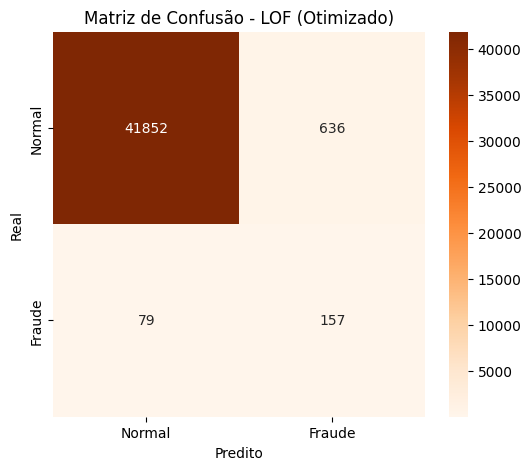

In [91]:
y_pred_val = (scores_val >= best_threshold).astype(int)
print(classification_report(y_val, y_pred_val, target_names=["Normal", "Fraude"]))
cm_lof = confusion_matrix(y_val, y_pred_lof)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lof, annot=True, fmt='d', cmap='Oranges', # Usei cor diferente para distinguir
            xticklabels=['Normal', 'Fraude'],
            yticklabels=['Normal', 'Fraude'])
plt.title('Matriz de Confusão - LOF (Otimizado)')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.show()

# **Deep Learning & Avançado**

In [ ]:
#Arquitetura Autoencoder

In [ ]:
#Pipeline de Treino Autoencoder

In [ ]:
#Definição de Threshold de Anomalia

In [ ]:
#Refinamento do Autoencoder

# **Avaliação e Validação Estatística**

In [ ]:
#Consolidação de Métricas

In [ ]:
#Visualização de Resultados

In [ ]:
#Teste de Significância Estatística

In [ ]:
#Análise de Falhas